<font size="6">  <strong> Example battery design</strong> <br>
<font size="5"> Automating the BatPaC model
   

The following notebook provides an example of the battery design module. The module uses BatPaC version 5 to solve the battery design based on user specific <br>
parameters and returns the material content of specific battery design. The adjustable parameters and parameter ranges can be found in the file <br>
'battery_design_parameters.xlsx'.

<br>
<img src='../fig/battery_design_overview.jpg' width=800/>


In [1]:
#Import required packages

import pandas as pd
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
sys.path.insert(1, r'C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model\batt_sust_model')
from battery_design import battery_design as bd


#Local Path to BatPaC version 5. 
# Make sure iterative calculations are enabled (100 iterations is sufficient, see BatPaC manual 3rd edition page 12):
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 10Feb2022.xlsm"

Overivew of parameter names, description and value ranges:

# Example 1 - Solving a single battery pack design
In the first example, the material content of a single battery is obtained. The geometric design of the Volkswagen ID.3 77 kWh version as reported by<br>
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example (NMC622 is used instead of NMC712, as the latter is not <br>
available in the current model):
* Vehicle type: battery electric vehicle
* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Cooling: liquid
* Modules in parallel: 2 <br>
<br>
All other parameters are BatPaC default parameters.


In [2]:
#Establish battery system class of specific design:
battery = bd.Battery_system ( vehicle_type='EV', electrode_pair='NMC622-G (Energy)', cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                             cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94)
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()




In [4]:
#Solve battery design in BatPaC returning nested dictionary with material contents and parameter values (takes between 5-10 seconds). 
#Make sure BatPaC is not open or running in the background. 
#BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

appending param pack_energy
appending param available_energy
appending param vehicle_type
appending param modules_per_row
appending param rows_of_modules
appending param cells_per_module
appending param cells_in_parallel
appending param electrode_pair
appending param sep_foil_thickness
done appending
silicon add
silicon add done
reset


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [10]:
from tabulate import tabulate

headers = [' ', 'BatPaC output', 'VW ID3.']
data = [['Usable capacity (kWh)', result_dict['general_battery_parameters']['pack_usable_energy_kWh'], 77],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Cell capacity (Ah)',round(result_dict['general_battery_parameters']['cell_capacity_ah'], 2),78],
        ['Total cells',result_dict['general_battery_parameters']['cells_per_pack'],288],
        ['Cell energy density (Wh/kg)', result_dict['general_battery_parameters']['specific_energy_cell_Wh/kg'],265]
       ]

print ('Results modelled pack versus VW3 ID3. pack as reported by PushEVS:\n')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled pack versus VW3 ID3. pack as reported by PushEVS:

                               BatPaC output    VW ID3.
---------------------------  ---------------  ---------
Usable capacity (kWh)                  77.08         77
Cell weight (kg)                       1.126      1.073
Cell capacity (Ah)                     76.25         78
Total cells                              288        288
Cell energy density (Wh/kg)          252.859        265


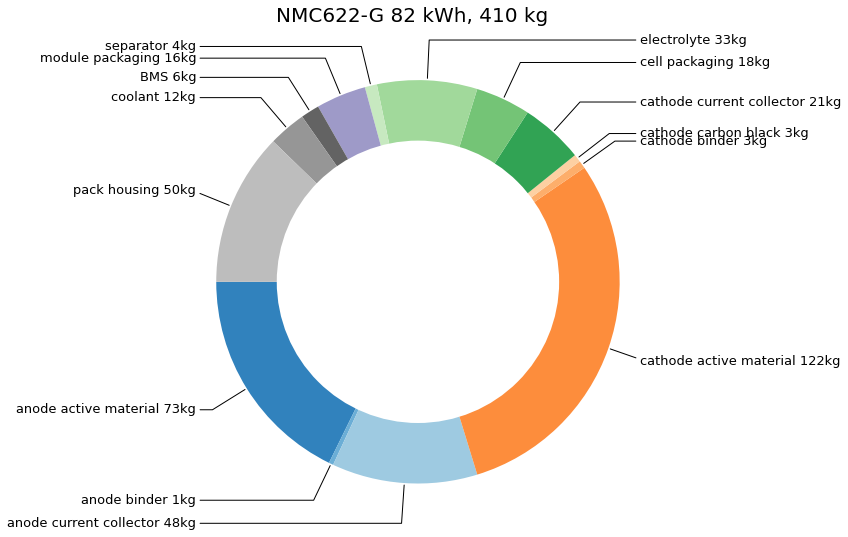

In [4]:
# Build-in donut diagram function of material content by material category
bd.plot_circle_diagram(result_dict)

### Export to Excel
Results can be exported to Excel, resulting in two files: 
* 3_MC_battery_pack_materials
* 3_PAR_battery_design parameters
<br>
The 3_MC includes the material content of the battery design, 3_PAR includes the design parameters and several technical parameters <br>
of the solved system obtained from BatPaC. 

In [5]:
# Results can be exported to XLSX format to be later used in the life cycle assessment, costing or material flow analysis model. 
bd.export_to_excel(result_dict, 'result_1')

# Example 2 - Solving multiple battery designs
In the following example, the battery design module is used to iterate through several design parameters and solve the battery system for several batteries. <br>
Using the function 'solve_batpac_battery_system_multiple', BatPaC is kept open in the background and the model solved for each design parameter (takes about 3 <br>
second to solve BatPaC in Excel with 100 iterations per calculation enabled). <br>

In this example, we will iterature through different cathode chemistries and current collector thickness to identify if the above results can be improved to better match the VW ID.3:

* cathode chemistry: NMC622-G and NMC811-G
* anode current collector thickness: 6 and 8
* cathode current collector thickness: 10 and 12
 <br>



In [104]:
import itertools as itertools

cathode_chemistry         = ['NMC622-G', 'NMC811-G']
anode_current_collector   = [6, 8]
cathode_current_collector = [10,12]

dict_design = {}

param_all = list(itertools.product(cathode_chemistry,anode_current_collector,cathode_current_collector))
for param in param_all:
    battery = bd.Battery_system (vehicle_type='EV', electrode_pair=param[0], cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                                 cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94, 
                                 negative_foil_thickness=param[1], positive_foil_thickness=param[2])
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[param] = parameter_dict
    

Solve BatPaC design model for all battery design options:
Make sure BatPaC is closed

In [105]:

result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=dict_design, visible=True)

In [72]:
data_all = []
for x in range(len(data)):
    data[result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh'] for x in result_dict_all.keys()]
    

In [103]:
headers = ['Example 1',*result_dict_all.keys(), 'VW ID3.']

import matplotlib.pyplot as plt

capacity = []
wt_cell = []
cap_cell= []
total_cell = []
density = []
for x in result_dict_all.keys():
    capacity.append(result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh'])
    wt_cell.append(round(result_dict_all[x]['material_content_pack']['cell']/result_dict_all[x]['general_battery_parameters']['cells_per_pack'],3))
    cap_cell.append(round(result_dict_all[x]['general_battery_parameters']['cell_capacity_ah'], 2))
    total_cell.append(result_dict_all[x]['general_battery_parameters']['cells_per_pack'])
    density.append(result_dict_all[x]['general_battery_parameters']['specific_energy_cell_Wh/kg'])

data[0][1:1]=capacity
data[1][1:1]=wt_cell
data[2][1:1]=cap_cell
data[3][1:1]=total_cell
data[4][1:1]=density


headers = ['Baseline',*[str(k) for k in result_dict_all.keys()], 'VW ID3.']

print ('Results modelled pack versus VW3 ID3. pack as reported by PushEVS:\n')
print(tabulate(data, headers=headers, numalign="right"))

NameError: name 'result_dict_all' is not defined

In [101]:
df=plot_bar_chart(result_dict,r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Modules\1_battery_design_module\data\component_type_linkage.xlsx")

In [81]:
df.T.iloc[1,:]

anode active material         72.555259
anode binder                    1.48072
anode current collector       47.722116
cathode active material      121.999832
cathode binder                 2.541663
cathode carbon black           2.541663
cathode current collector     20.634558
cell packaging                18.025699
electrolyte                    32.81621
separator                      3.973969
module packaging              16.394612
BMS                              6.0832
coolant                       12.302264
pack housing                  50.175264
Name: result, dtype: object

<AxesSubplot:>

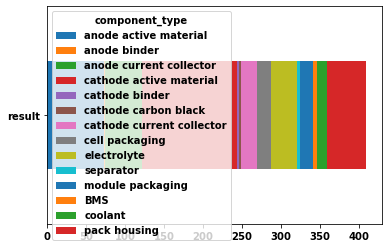

In [98]:
df.T.plot(kind='barh', stacked=True)

In [108]:
dic = {}
for x in result_dict_all.keys():
    dic[x] = plot_bar_chart(result_dict_all[x], name=x)
    

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [106]:
from pathlib import Path
import numpy as np

def plot_bar_chart (result_dict, path_comp_type_linkage=None, save=True, name=None):
    """ Plots a donut diagram of the battery bills of material
    Args:
        result_dict (dict): dictionary of battery design module output by name
        comp_type_linkage (str): Path to Excel sheet with battery components by type. Default location is 1_battery_design_module
    """   
    df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

    result = result_dict['material_content_pack']

    df_types[name] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    df_types.drop('part_off', axis=1, inplace=True)
    labels = list(df_types.index)
    values = list(df_types['result'])

    return df_types


In [5]:
else:
        df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

    result = result_dict['material_content_pack']

    df_types['result'] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    labels = list(df_types.index)
    values = list(df_types['result'])
    fig, ax = plt.subplots(figsize=(8, 8))
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    label_kg = []
    for x in range(len(labels)):
        label_kg.append(f'{labels[x]} {round(values[x])}kg')

    cmap = plt.get_cmap("tab20c")
    inner_colors = cmap([0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 19])

    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0, 1))
            return '{v:d}'.format(v=val)

        return my_format

    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=180, colors=inner_colors)

    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              # bbox=bbox_props,
              zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(label_kg[i], xy=(x, y), xytext=(1.1 * np.sign(x), 1.2 * y),
                    horizontalalignment=horizontalalignment, **kw, fontsize=13)

    capacity = round(result_dict['general_battery_parameters']['pack_energy_kWh'])
    electrode = result_dict['general_battery_parameters']['electrode_pair']
    weight = round(result_dict['material_content_pack']['battery pack'])
    plt.suptitle(f'{electrode} {capacity} kWh, {weight} kg', fontsize=20)

    ax.axis('equal')
    # plt.tight_layout()
    if save is False:
        return plt.show()
    if save is True:
        if name is False:
            plt.savefig(f'material content {electrode} {capacity} kWh.png', bbox_inches = "tight")
        plt.savefig(f'{name}.png', bbox_inches = "tight")
        return plt.show()

NameError: name 'result_dict' is not defined

# IMPROVE EXPORT FOR ALL!!!!

In [6]:
#Export to excel:
for battery_design in result_dict_all.keys():
    bd.export_to_excel(result_dict_all[battery_design], str(battery_design), overwrite=True)